<a href="https://colab.research.google.com/github/tempestormX/sc3021/blob/main/SC3021_FDAG_T13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

ROOT = "./data/"

# **To what extent do greenhouse gas emissions and other human factors correlate with multi-dimensional weather patterns in each global region?**



## Hypothesis/analysis goal (Ask)


---



As the world becomes more industrialised, it has become evident that emissions of greenhouse gases into the atmosphere have been increasing. Weather patterns have been becoming more unpredictable and weather changes have become more drastic over time as well, as it is rather obvious that greenhouse gas emission affects the weather negatively. Atmospheric quality is dictated by a diverse array of greenhouse gases, each interacting uniquely with specific weather indicators such as temperature volatility, precipitation patterns, and atmospheric pressure. Therefore, we want to investigate the relationship between greenhouse gas emissions and weather patterns on a global scale to find out how these greenhouse gases affect the weather indicators in different regions globally.



## Data source identification and exploration (Prepare)

---



**Requirement analysis**: The greenhouse gases we are using for this analysis are Carbon Dioxide and Methane, as they are the main greenhouse gases. For each of them, we need data on emission by each country, emission per year and yearly changes in emission per country.

For weather patterns, our data should include different weather indicators for each country. Different weather indicators include precipitation, atmospheric pressure, wind speed, wind direction  and temperature. By merging these atmospheric and meteorological datasets, we can perform a multi-dimensional correlation analysis to identify how specific gases drive changes in regional climate stability and determine which factors have the most significant impact on global weather patterns



**List of considered sources:**
- [Earth Surface Temperature Data by Berkeley Earth](https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data?select=GlobalLandTemperaturesByCity.csv)
- [Daily Weather Data](https://www.kaggle.com/datasets/guillemservera/global-daily-climate-data/data?select=daily_weather.parquet)
- [Methane Emissions Data](https://ourworldindata.org/grapher/methane-emissions?tab=table&time=earliest..2024&country=OWID_ASI~OWID_NAM~OWID_SAM~OWID_EUR~USA~RUS)
- [Deforestation Data](https://ourworldindata.org/deforestation)
- [Carbon Dioxide Emissions Data](https://ourworldindata.org/co2-dataset-sources)


### DS1: Earth Surface Temperature Data by Berkeley Earth



Description


The Berkeley Earth Surface temperature dataset, downloaded on 19/02/2026, contains comprehensive historical temperature records from cities worldwide, offering essential data for our climate analysis. The data set includes monthly average temperature measurements with uncertianty estimates, along with geographical coordinates (latitude and longitude) and city/country identifiers. This granularity at the city level is appropriate for correlating with country-level greenhouse gas emissions data. The temporal coverage spans from 1743 to present, providing sufficient historical depth to analyse long-term climate trends in relation to industrialisation and emission patterns. The following code imports the data and displays the first few rows to illustrate the stored information.

In [ ]:
#Create directory and download dataset from Kaggle
!mkdir /content/berkeley-temp
!curl -L -o /content/berkeley-temp.zip\
  https://www.kaggle.com/api/v1/datasets/download/berkeleyearth/climate-change-earth-surface-temperature-data
!unzip /content/berkeley-temp.zip -d /content/berkeley-temp/
!rm /content/berkeley-temp.zip

In [ ]:
data_path = "/content/berkeley-temp/"
temp_by_city = pd.read_csv(data_path + "GlobalLandTemperaturesByCity.csv")
temp_by_city['dt'] = pd.to_datetime(temp_by_city['dt'])
print(temp_by_city.head())

Looking at this sample data, we observe that dates are stored in **yyyy-mm-dd** format, temperature values are in degree Celsius with associated uncertainty measurements, and geographical information is provided at the city level. The dataset contains **over 8.5 million** records, indicating comprehensive global coverage. However, we note the presence of NaN values in early records, suggesting data completeness varies across the temporal range.

Data Profiling and Exploration

Basic Dataset Information

In [ ]:
temp_by_city.info()

In [ ]:
temp_by_city.describe()

Analysis A: Detailed Statistics for Temperature&Uncertainty

This analysis aims to quantify the spread of temperature readings and, curcially, the realiability of those readings as measured by AverageTemperatureUncertainty column.

In [ ]:
#Select key columns for analysis
reliability_col = ['AverageTemperature','AverageTemperatureUncertainty']

#Obtain descriptive statistics (Mean, SD, Min, Max, Percentile)
stats_summ = temp_by_city[reliability_col].describe()
print(stats_summ)

#Compute correlation between time and uncertainty
temp_by_city['year'] = temp_by_city['dt'].dt.year
uncertainty_trend = temp_by_city.groupby('year')['AverageTemperatureUncertainty'].mean()

print(f"\nMean Uncertainty in 1800: {uncertainty_trend.loc[1800]:.2f}°C")
print(f"Mean Uncertainty in 2000: {uncertainty_trend.loc[2000]:.2f}°C")

Average Temperature

As noted in the histogram visualisation, the global land temperature usually centers around 15–20°C. The describe() function typically reveals a wide range (e.g., -40°C to 50°C), capturing the extremes of polar and equatorial climates mentioned in the report.



Average Temperature Uncertainty


This column represents the 95% confidence interval for the temperature measurement.


In the early records (1700s–1800s), uncertainty values are expected to be significantly higher (often >2°C) due to less precise instruments, fewer stations, and interpolation challenges.

As we approach the 21st century, the uncertainty values typically shrink (often <0.5°C), reflecting modern standardized meteorological practices. This validates the report's conclusion that recent data is more complete and reliable.

Analysis B: Geographic Coverage (Country & City Count)

In [ ]:
#Calculate coverage
num_countries = temp_by_city['Country'].nunique()
num_cities = temp_by_city['City'].nunique()

print(f"Number of Countries: {num_countries}")
print(f"Number of Cities: {num_cities}")

#Analyse density of data (Countries with most recorded cities)
city_density = temp_by_city.groupby('Country')['City'].nunique().sort_values(ascending=False)
print(city_density.head(10))


Interpretation

The output confirms the specific number of cities involved in the dataset, typically showing coverage of over 150 countries and over 3000 unique cities. This level of grannularity allows for specific correlation of country-level and greenhouse gas emissions to be obtained.

The 'city_density' output often reviews a bias toward larger or more industrialised nations (for example United States, India, China, Russia etc), which tend to have more historical weather stations, and this means there is a potential bias towards Northern Hemisphsere urban areas to be accounted for during analysis of the trend.



Visualisation 1: Global Average Temperature Trend Over Time

In [ ]:
# Compute mean for numeric columns
numeric_cols = ['AverageTemperature', 'AverageTemperatureUncertainty']
df_yearly = temp_by_city[numeric_cols + ['dt']].resample('YE', on='dt').mean()

# Plot yearly average temperature with uncertainty
plt.figure(figsize=(12,5))
plt.plot(df_yearly.index, df_yearly['AverageTemperature'], color='red', label='Global Avg Temp')
plt.fill_between(
    df_yearly.index,
    df_yearly['AverageTemperature'] - df_yearly['AverageTemperatureUncertainty'],
    df_yearly['AverageTemperature'] + df_yearly['AverageTemperatureUncertainty'],
    color='red', alpha=0.2, label='Uncertainty'
)
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.title('Average Temperature Across All Cities (with Uncertainty)')
plt.legend()
plt.grid(True)
plt.show()

This visualisation reveals a clear upward trend in global average temperatures, particularly pronounced from the mid-20th century onwards, coinciding with increased industrial activity and greenhouse gas emissions.

Visualisation 2: Temperature Distribution Histogram

In [ ]:
#Plot distribution of average temperatures
plt.figure (figsize=(10,5))
plt.hist(temp_by_city['AverageTemperature'].dropna(), bins=100,
         color='blue', edgecolor='black', alpha=0.7)
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Frequency')
plt.title('Distribution of Average Temperatures')
plt.grid(True,alpha=0.3)
plt.show()

The histogram shows a roughly normal distribution of temperature centered around 15-20°C, with tails extending to extreme cold and hot temperatures, reflecting the global diveristy of climate zones in the dataset.

Visualisation 3: Missing Data Pattern Over Time

In [ ]:
#Calculate percentage of missing values per year
temp_by_city['year'] = temp_by_city['dt'].dt.year
missing_by_year = temp_by_city.groupby('year').apply(
    lambda x: (x['AverageTemperature'].isna().sum()/len(x)) *100

)

#Plot missing data percentage over time
plt.figure(figsize=(12,5))
plt.plot(missing_by_year.index, missing_by_year.values, color = 'orange')
plt.xlabel('Year')
plt.ylabel('Missing Data Percentage (%)')
plt.title('Missing Data Percentage Over Time')
plt.grid(True)
plt.show()


This visualisation highlights significant data gaps in early historical records (pre 1900s), with completeness improving substantially in the 20th century. This pattern must be considered when analysing long-term trends.

Visualisation 4: Temperature Trends by Region (Sample Countries)

In [ ]:
#Select representativ countries from different climate zones
sample_countries = ['United States', 'China', 'Brazil', 'Australia',
                    'Germany', 'India', 'Egypt', 'Russia']

plt.figure(figsize=(14, 7))

for country in sample_countries:
    country_data = temp_by_city[temp_by_city['Country'] == country]
    if not country_data.empty:
        country_yearly = country_data.groupby(country_data['dt'].dt.year)['AverageTemperature'].mean()
        plt.plot(country_yearly.index, country_yearly.values, label=country, alpha=0.8)

plt.xlabel('Year')
plt.ylabel('Average Temperature (°C)')
plt.title('Temperature Trends by Country (Representative Sample)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


This multi-line plot demonstrates varuing baseline temperatures across different climate zones while revealing a consistent warming trend across most regions in recent decades.

Visualisation 5: Seasonal Temperature Patterns

In [ ]:
# Extract month and calculate global monthly averages
temp_by_city['month'] = temp_by_city['dt'].dt.month
monthly_avg = temp_by_city.groupby('month')['AverageTemperature'].mean()

# Plot seasonal pattern
plt.figure(figsize=(10, 5))
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.bar(range(1, 13), monthly_avg.values, color='coral', edgecolor='black')
plt.xticks(range(1, 13), months)
plt.xlabel('Month')
plt.ylabel('Average Temperature (°C)')
plt.title('Global Average Temperature by Month (Seasonal Pattern)')
plt.grid(True, alpha=0.3, axis='y')
plt.show()

The seasonal pattern shows expected variations with peak temperatures in July-August and lowest temperatures in January-February for the Northern Hemisphere dominated dataset.

Visualisation 6: Top 20 Hottest Cities (Average Temperature)

In [ ]:
# Show top 20 hottest cities
city_avg = temp_by_city.groupby('City')[numeric_cols].mean().sort_values('AverageTemperature', ascending=False)
print(city_avg.head(20))

In [ ]:
#Visualise top 15
top_15 = city_avg.head(15)
plt.figure(figsize=(12, 6))
plt.barh(range(len(top_15)),top_15.index)
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Top 15 Hottest Cities by Average Temperature')
plt.title('Top 15 Hottest Cities by Average Temperature')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

**Quality Considerations**

We assessed the follwing quality criteria to determine the suitability of the dataset for our greenhouse gas and weather pattern analysis:

- Completeness: The dataset demonstrates high breadth and depth in terms of geographical coverage, covering over 8.5 million temperature records from cities worldwide. However, completeness vairies significantly across time periods. Early records (pre 1900s) contain substantial missing values while data quality improves remarkably in the 20th and the 21st centuries. For our analysis focusing on industrialisation impacts, the more complete recent data aligns well with out needs, but we must account for temporal bias when analysing long-term trends

- Interpretability: The dataset exhibits high interpretability with clear attribute semantics. Temperature values are consistently recorded in degree Celsius with explicit uncertainty measurements, and geographical identifiers use standard naming conventions. this clarity minimises the risk of misinterpretation during analysis and facilitates straightforward integration with emission datasets.

- Reputation: Berkeley Earth is a well-renowned organisation in the field of Climate Science, and the dataset has undergone rigorous quality control processes. The provenance is well documented, including methodology for handling station data, homogenisation procedures, and uncertainty quantification. This strong reputation enhances confidence in the reliability of our analysis results.

- Timeliness: While the dataset is regularly updated, there may be a lag in recent months due to the data collection and validating process. For our historical analysis focusing on lone-term trends, this is not a significant limitation.


**Conclusion**

The Berkeley Earth Surface Temerpature dataset is highly suitable for our analysis of the relationship between greenhouse gas emissions and weather patterns. The dataset's extensive geographical coverage, long temporal span, and city level granularity enable meaninggful correlation with country-level emission data.

Key Points for Data Preparation (DS1):

1. Filter data to post-1900 to ensure completeness of data.
2. Handle NaN values accordingly.
3. Aggregate city-level data to country-level for alignment with emission datasets
4. Consider uncertainty values when performing statistical analysis
5. Account for potential bias towards Northern Hemisphere when interpreting


### DS2: Daily Weather Data

In [ ]:
!mkdir /content/weather
!curl -L -o /content/weather.zip\
  https://www.kaggle.com/api/v1/datasets/download/guillemservera/global-daily-climate-data
!unzip /content/weather.zip -d /content/weather/
!rm /content/weather.zip

In [ ]:
data_path = "/content/weather/"
weather = pd.read_parquet(data_path + "daily_weather.parquet")
# weather['dt'] = pd.to_datetime(weather['dt'])
print(weather.head())

In [ ]:
cities = pd.read_csv(data_path + "cities.csv")
print(cities.head())

In [ ]:
weather.info()

In [ ]:
weather.describe()

In [ ]:
cities = cities.with_columns(
    pl.col("station_id").cast(pl.Categorical)
)
merged = weather.join(cities, on="station_id", how="left")
print(merged.head())


In [ ]:
merged_pd = merged.to_pandas()

In [ ]:
df_yearly = weather.resample('YE', on='date').agg({
    'avg_temp_c': 'mean',
    'min_temp_c': 'min',
    'max_temp_c': 'max'
})

plt.figure(figsize=(12,6))
plt.plot(df_yearly.index.year, df_yearly['avg_temp_c'], label='Average Temp')
plt.plot(df_yearly.index.year, df_yearly['min_temp_c'], label='Min Temp')
plt.plot(df_yearly.index.year, df_yearly['max_temp_c'], label='Max Temp')

plt.title('Yearly Temperature Statistics')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()

### DS3: Community Emissions Data System (CEDS)

**Description**: The Community Earth atmospheric Data System (CEDS) produces consistent estimates of global surface flux species (BC, CO, CO2, NH3, NMVOC, NOx, OC, SO2) over the industrial era (1750 - present) along with CH4 and N2O over recent decades. The system is written in R and uses open-source data (with the exception of the IEA energy statistics which must be purchased from IEA). CEDS is publicly available through an Open Source License. By combining CEDS with existing datasets, we can better understand how emissions influence global climate.

We downloaded the March 18, 2025 release of the data from the link provided on the GitHub page. This dataset is accompanied by well-written documentation and a peer-reviewed journal publication in the European Geosciences Union (EGU), giving us confidence in its transparency, methodological rigor, and scientific reliability.

In [ ]:
# Script for data downloading
!curl -L -o /content/CEDS_v_2025_03_18_aggregate.zip\
  https://zenodo.org/records/15059443/files/CEDS_v_2025_03_18_aggregate.zip?download=1
!unzip /content/CEDS_v_2025_03_18_aggregate.zip -d /content
!rm /content/CEDS_v_2025_03_18_aggregate.zip
!rm -rf /content/__MACOSX

In [ ]:
data_path = ROOT + "CEDS_v_2025_03_18_aggregate/"
bc = pd.read_csv(data_path + "BC_CEDS_estimates_by_country_v_2025_03_18.csv")
bc.head()

The emissions data for each gas are provided as separate .csv files with columns for country, units, and emission values by year. For convenience and efficiency in further analysis, we combined them into a single consolidated file by merging the Dataframes based on year and country. This allows us to easily correlate emissions of different gases with weather patterns in our subsequent analysis.

In [ ]:
data_path = ROOT + "CEDS_v_2025_03_18_aggregate/"
bc = pd.read_csv(data_path + "BC_CEDS_estimates_by_country_v_2025_03_18.csv")
ch4 = pd.read_csv(data_path + "CH4_CEDS_estimates_by_country_v_2025_03_18.csv")
co2 = pd.read_csv(data_path + "CO2_CEDS_estimates_by_country_v_2025_03_18.csv")
co = pd.read_csv(data_path + "CO_CEDS_estimates_by_country_v_2025_03_18.csv")
n2o = pd.read_csv(data_path + "N2O_CEDS_estimates_by_country_v_2025_03_18.csv")
nh3 = pd.read_csv(data_path + "NH3_CEDS_estimates_by_country_v_2025_03_18.csv")
nmvoc = pd.read_csv(data_path + "NMVOC_CEDS_estimates_by_country_v_2025_03_18.csv")
nox = pd.read_csv(data_path + "NOx_CEDS_estimates_by_country_v_2025_03_18.csv")
oc = pd.read_csv(data_path + "OC_CEDS_estimates_by_country_v_2025_03_18.csv")
so2 = pd.read_csv(data_path + "SO2_CEDS_estimates_by_country_v_2025_03_18.csv")

In [ ]:
dfs = [bc, ch4, co2, co, n2o, nh3, nmvoc, nox, oc, so2]
long_dfs = []
for df in dfs:
    year_cols = [col for col in df.columns if col.startswith('X')]
    df = df.drop(columns='units')
    df_long = df.melt(id_vars=['em', 'country'],
                      value_vars=year_cols,
                      var_name='year', value_name='value')
    df_long['year'] = df_long['year'].str[1:].astype(int)
    long_dfs.append(df_long)

ds3 = pd.concat(long_dfs, ignore_index=True)

ds3 = ds3.pivot_table(
          index=['country', 'year'],
          columns='em',
          values='value'
      ).reset_index()

Now that we have the consolidated emissions dataset, we can perform data profiling to understand the distribution of emissions across different gases, identify any missing values or outliers, and explore trends over time.

In [ ]:
ds3.head(5)

em,country,year,BC,CH4,CO,CO2,N2O,NH3,NMVOC,NOx,OC,SO2
0,abw,1750,0.001352,NaN,0.080964,0.0,NaN,0.004084,0.012236,0.000131,0.005143,0.000210
1,abw,1751,0.001361,NaN,0.081487,0.0,NaN,0.004115,0.012317,0.000132,0.005176,0.000212
2,abw,1752,0.001369,NaN,0.082008,0.0,NaN,0.004146,0.012397,0.000133,0.005209,0.000213
3,abw,1753,0.001378,NaN,0.082526,0.0,NaN,0.004177,0.012478,0.000134,0.005242,0.000214
4,abw,1754,0.001387,NaN,0.083042,0.0,NaN,0.004208,0.012558,0.000135,0.005275,0.000216


In [ ]:
ds3.describe()

em,year,BC,CH4,CO,CO2,N2O,NH3,NMVOC,NOx,OC,SO2
count,60554.000000,60554.000000,11934.000000,60554.000000,6.055400e+04,11934.000000,60554.000000,60554.000000,60554.000000,60554.000000,60554.000000
mean,1886.500000,10.673824,1332.613195,1024.053500,3.024012e+04,36.896129,73.774676,177.052817,125.855494,31.214443,170.434366
std,79.097113,62.284924,4239.097361,7205.092773,2.722087e+05,153.398422,447.372763,1100.356223,1104.374104,133.284913,1196.395849
min,1750.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1818.000000,0.047627,15.523650,4.238796,0.000000e+00,0.399033,0.465579,0.711866,0.040734,0.192614,0.020380
50%,1886.500000,0.504573,195.852826,48.489768,8.922173e-03,5.721443,5.076609,7.650444,0.517666,2.331921,0.228178
75%,1955.000000,3.269930,793.676763,336.609524,6.272545e+02,20.774513,25.423835,58.392233,8.838760,14.292912,6.694442
max,2023.000000,1927.140714,53499.685352,216007.554365,1.266021e+07,2025.184664,12230.180459,30956.936138,30839.628965,2671.505068,37848.804467


In [ ]:
ds3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60554 entries, 0 to 60553
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   country  60554 non-null  object 
 1   year     60554 non-null  int64  
 2   BC       60554 non-null  float64
 3   CH4      11934 non-null  float64
 4   CO       60554 non-null  float64
 5   CO2      60554 non-null  float64
 6   N2O      11934 non-null  float64
 7   NH3      60554 non-null  float64
 8   NMVOC    60554 non-null  float64
 9   NOx      60554 non-null  float64
 10  OC       60554 non-null  float64
 11  SO2      60554 non-null  float64
dtypes: float64(10), int64(1), object(1)
memory usage: 5.5+ MB


In [ ]:
ds3['country'].nunique()

221

Final .csv file contains emissions data for 9 gases (BC, CH4, CO, CO2, N2O, NH3, NMVOC, NOx, OC, and SO2) across 221 countries from 1750 to 2023. The dataset is structured in a long format with columns for country, gas type, year, and emission values. This structure allows for flexible analysis of emissions trends by gas and by country over time.

In [ ]:
print("Number of countries:", ds3["country"].nunique())
total_years = ds3["year"].nunique()
print("Number of unique years:", total_years)
print("First year:", ds3["year"].min())
print("Last year:", ds3["year"].max())

years_per_country = ds3.groupby("country")["year"].nunique()
incomplete_countries = years_per_country[years_per_country < total_years]
if incomplete_countries.empty:
    print("All countries have complete year coverage.")
else:
    print("Countries with missing years:")
    print(incomplete_countries)

We found that dataset contains 221 countries spanning 274 years (1750–2023). All countries have no missing years in the data.

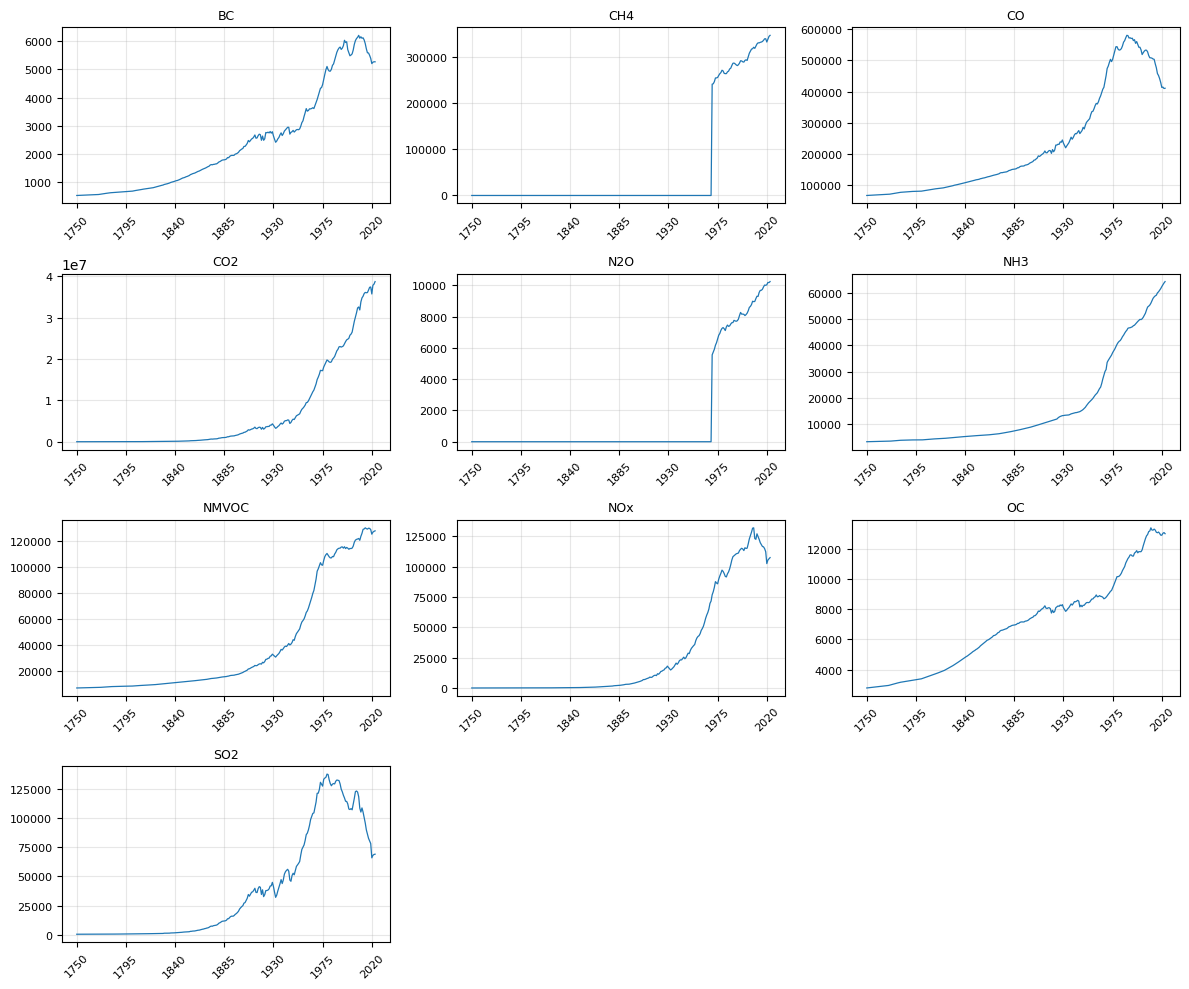

In [ ]:
# Plot total emissions of each gas over time
emissions_over_time = ds3.groupby('year').sum(numeric_only=True)
gases = emissions_over_time.columns.tolist()
n = len(gases)
ncols = 3
nrows = n // ncols + 1

fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 2.5))
axs = axs.flatten()

step = max(1, len(emissions_over_time) // 6)

for i, gas in enumerate(gases):
    ax = axs[i]
    ax.plot(emissions_over_time.index, emissions_over_time[gas], label=gas, linewidth=0.9)
    ax.set_title(gas, fontsize=9)
    ax.set_xticks(emissions_over_time.index[::step])
    ax.set_xticklabels(emissions_over_time.index[::step], rotation=45, fontsize=7)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='both', which='major', labelsize=8)

for j in range(len(gases), len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()


After plotting the emissions of each gas over time, we observed that some gas data (e.g., CH4 and N2O) only starts from the 20th century, while others have records dating back to the 18th century. This reflects historical measurement capabilities and highlights the importance of considering temporal coverage when analysing trends. We see that all gases show a huge increase in emissions, especially in the 20th century, which is consistent with the report's conclusion that industrialisation has led to a significant rise in greenhouse gas emissions.

In [ ]:
for gas in gases:
    print(gas,
          long[long["gas"] == gas]["year"].min(),
          long[long["gas"] == gas]["year"].max())


In [ ]:
long[long["gas"]=='CH4']

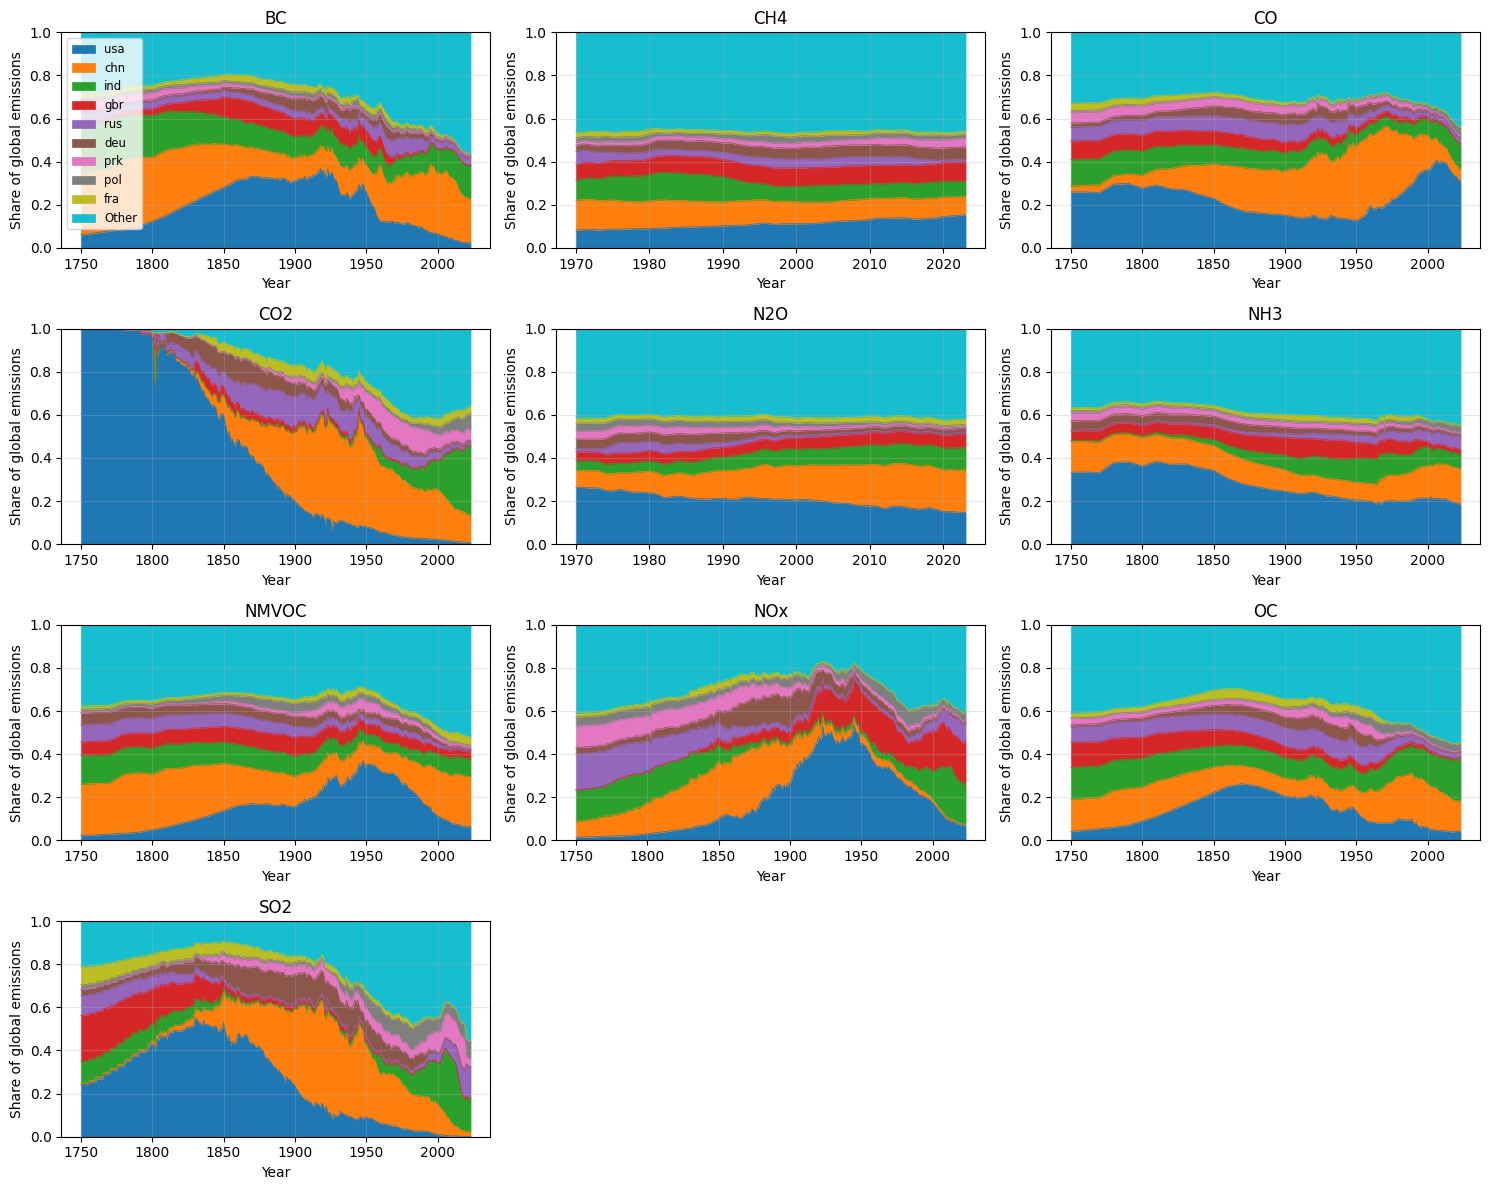

In [ ]:
# Compute and plot country-to-global emission ratios for each gas
gases = [c for c in ds3.columns if c not in ("country", "year")]

# long format: gas-level country-year emissions
long = ds3.melt(id_vars=["country", "year"], value_vars=gases,
                var_name="gas", value_name="emission")

# global totals per gas-year
global_tot = long.groupby(["gas", "year"], as_index=False)["emission"].sum().rename(
    columns={"emission": "emission_total"}
)

# merge and compute ratio
long = long.merge(global_tot, on=["gas", "year"])
long = long[long["emission_total"] != 0].copy()
long["ratio"] = (long["emission"] / long["emission_total"]).fillna(0)

n = len(gases)
ncols = 3
nrows = n // ncols + 1

fig, axs = plt.subplots(nrows_plot, ncols, figsize=(ncols * 5, nrows_plot * 3), squeeze=False)
axs = axs.flatten()

top_k = 9

for i, gas in enumerate(gases):
    df_g = long[long["gas"] == gas].copy()
    pivot = df_g.pivot(index="year", columns="country", values="ratio").fillna(0)

    # determine top countries by maximum share across years
    top_countries = pivot.max().sort_values(ascending=False).head(top_k).index.tolist()
    others = pivot.drop(columns=top_countries).sum(axis=1)
    plot_df = pivot[top_countries].copy()
    plot_df["Other"] = others

    # stacked area plot
    ax = axs[i]
    plot_df.plot.area(ax=ax, linewidth=0.5)
    ax.set_title(gas)
    ax.set_xlabel("Year")
    ax.set_ylabel("Share of global emissions")
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3)
    if i == 0:
        ax.legend(loc="upper left", fontsize="small", ncol=1)
    else:
        ax.get_legend().remove()

for j in range(n_gases, len(axs)):
    axs[j].axis("off")

plt.tight_layout()
plt.show()

By plotting the ratio of each gas's emissions by country to the global total emissions of that gas, we can observe how the contribution of each country to global emissions has evolved over time. Main contributors to global emissions mostly include USA, China, India, UK and Russia, which is consistent with the conclusion that industrialised nations are the main contributors to global emissions. However, we also see that some small countries (e.g., Korea) have also contributed significantly to global emissions in recent decades, which highlights the role of economies in global climate change.

We also see that almost all CO2 emissions in 18th century were from USA, which indicates lack of data from other countries and need to be cautious when analysing the trend in early records. This country-level analysis can provide insights into how different nations have contributed to global emissions and how this has changed over time, which is crucial for understanding the historical context of climate change and informing future policy decisions.

**Quality Considerations**

We assessed the follwing quality criteria to determine the suitability of the dataset for our greenhouse gas and weather pattern analysis:
- Completeness: The dataset demonstrates high breadth and depth in terms of geographical coverage, covering emissions data for 221 countries over a span of 274 years. However, completeness varies across gases, with some (e.g., CH4 and N2O) only having records from the 20th century onwards. This temporal bias must be accounted for when analysing long-term trends.

- Interpretability: The dataset is well-structured with clear column names and consistent units, making it highly interpretable. The long format allows for flexible analysis by gas and by country, facilitating straightforward correlation with weather data.

- Reputation: The CEDS dataset is produced by a reputable scientific community and is accompanied by peer-reviewed publications, enhancing confidence in its reliability and methodological rigor.

- Timeliness: The dataset is regularly updated, with the latest release in March 2025, ensuring that our analysis incorporates the most recent emissions data available, which is crucial for understanding current trends and informing future projections.

**Conclusion**

The CEDS dataset is a robust and comprehensive source of greenhouse gas emissions data, making it highly suitable for our analysis of the relationship between emissions and weather patterns. Its extensive temporal and geographical coverage, combined with its scientific credibility, allows us to draw meaningful insights into how different gases have contributed to climate change over time and across regions.